# Availability of adult and pediatric ICU beds and occupancy for COVID-related critical illness (CRCI)

## 1.0 Data Preparation

### 1.1 Data Import

This dataset comes from [Ontario Data Catalogue](https://data.ontario.ca/en/dataset/availability-of-adult-icu-beds-and-occupancy-for-covid-related-critical-illness-crci) and it compiles daily counts of patients (both COVID-related and non-COVID-related) in adult and pediatric ICU beds and the number of adult and pediatric ICU beds that are unoccupied.

In [1]:
# Set up modules.
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt, dates as mdates

# Import the csv file using `date` as index.
df_icu_beds = pd.read_csv('icu_beds.csv', index_col = 'date')

### 1.2 Data Inspection
The earliest record is dated May 1, 2020 and the latest Feb 2, 2023. There is no missing daily entry since the dataset spans 1008 days and there are 1008 records. There is no missing data in any column of the DataFrame. The following features are included:

| Name                          | Description                                                                   |
| :--                           | :--                                                                           |
| `adult_icu_crci_patients`     | number of adults in ICU for COVID-related critical illness (CRCI)             |
| `adult_icu_non_crci_patients` | number of adults in ICU for non-CRCI reasons                                  |
| `available_adult_icu_beds`    | number of adult ICU beds that are unoccupied                                  |
| `total_adult_icu_patients`    | total number of adults in ICU for any reason                                  |
| `total_adult_icu_beds`        | total number of adult ICU beds                                                |
| `ped_icu_crci_patients`       | number of patients in pediatric ICU for COVID-related critical illness (CRCI) |
| `ped_icu_non_crci_patients`   | number of patients in pediatric ICU beds for non-CRCI reasons                 |
| `available_ped_icu_beds`      | number of pediatric ICU beds that are unoccupied                              |
| `total_ped_icu_patients`      | total number of patients in pediatric ICU beds for any reason                 |
| `total_ped_icu_beds `         | total number of pediatric ICU beds                                            |

In [2]:
df_icu_beds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 2020-05-01 to 2023-02-02
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   adult_icu_crci_patients      1008 non-null   int64
 1   adult_icu_non_crci_patients  1008 non-null   int64
 2   available_adult_icu_beds     1008 non-null   int64
 3   total_adult_icu_patients     1008 non-null   int64
 4   total_adult_icu_beds         1008 non-null   int64
 5   ped_icu_crci_patients        1008 non-null   int64
 6   ped_icu_non_crci_patients    1008 non-null   int64
 7   available_ped_icu_beds       1008 non-null   int64
 8   total_ped_icu_patients       1008 non-null   int64
 9   total_ped_icu_beds           1008 non-null   int64
dtypes: int64(10)
memory usage: 86.6+ KB


In [3]:
# Check if there is any missing daily entry.
dates = pd.to_datetime(df_icu_beds.index)
(dates[-1] - dates[0]).days + 1

1008

In [4]:
# Convert the indices to pandas datetime objects
df_icu_beds.index = pd.to_datetime(df_icu_beds.index)

In [5]:
# Since all features relate to ICU, the `icu_` substring can be dropped from all column names for ease of coding.
df_icu_beds.columns = df_icu_beds.columns.str.replace('icu_', '')
df_icu_beds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2020-05-01 to 2023-02-02
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   adult_crci_patients      1008 non-null   int64
 1   adult_non_crci_patients  1008 non-null   int64
 2   available_adult_beds     1008 non-null   int64
 3   total_adult_patients     1008 non-null   int64
 4   total_adult_beds         1008 non-null   int64
 5   ped_crci_patients        1008 non-null   int64
 6   ped_non_crci_patients    1008 non-null   int64
 7   available_ped_beds       1008 non-null   int64
 8   total_ped_patients       1008 non-null   int64
 9   total_ped_beds           1008 non-null   int64
dtypes: int64(10)
memory usage: 86.6 KB


For each group of patients, the following relations exist between features:
- number of CRCI patients + number of Non-CRCI patients = total number of patients
- number of available beds + total number of patients (i.e. total number of beds occupied) = total number of beds

In [6]:
# Check the aforementioned relations.
print(
    ((df_icu_beds['adult_crci_patients'] + df_icu_beds['adult_non_crci_patients']) == df_icu_beds['total_adult_patients']).all(),
    ((df_icu_beds['available_adult_beds'] + df_icu_beds['total_adult_patients']) == df_icu_beds['total_adult_beds']).all(),
    ((df_icu_beds['ped_crci_patients'] + df_icu_beds['ped_non_crci_patients']) == df_icu_beds['total_ped_patients']).all(),
    ((df_icu_beds['available_ped_beds'] + df_icu_beds['total_ped_patients']) == df_icu_beds['total_ped_beds']).all()
)

True True True True


### 1.3 Additional Features

In [7]:
# df_icu_beds = df_icu_beds.assign(
#     crci_patients=lambda x:x['adult_crci_patients'] + x['ped_crci_patients'],
#     non_crci_patients=lambda x:x['adult_non_crci_patients'] + x['ped_non_crci_patients'],
#     available_beds=lambda x:x['available_adult_beds'] + x['available_ped_beds'],
# )

In [8]:
# Set global figure size and dpi.
# plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["figure.dpi"] = 100

In [21]:
def set_timeline(ax):
    ax.set_xlabel('Date')
    # ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m\n%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
    ax.tick_params(axis='x', which='minor', pad=5)

## 2.0 EDA

### 2.1 Adult versus pediatric CRCI patients

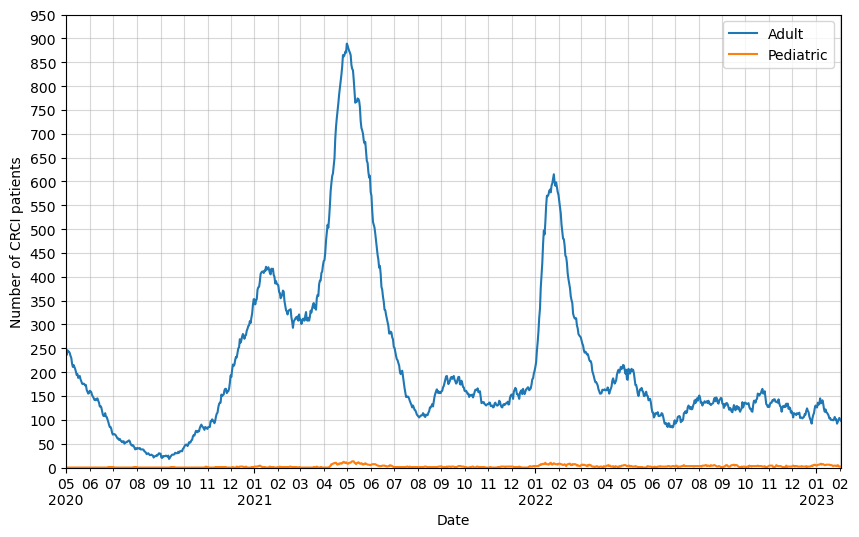

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_icu_beds[['adult_crci_patients', 'ped_crci_patients']])
ax.legend(['Adult', 'Pediatric'])
ax.set_ylabel('Number of CRCI patients')

ax.set_xlim(df_icu_beds.index[0], df_icu_beds.index[-1])
ax.set_xticks(df_icu_beds[~df_icu_beds.index.year.duplicated()].index)

ax.set_ylim(0, 900)
ax.set_yticks(np.arange(0,960,50))

ax.set_xlabel('Date')
set_timeline(ax)

ax.grid(which='both', alpha=0.5)

In [12]:
# adult_corr_matrix = df_icu_beds.loc[:, 'adult_crci_patients':'total_adult_beds'].corr()
# sns.heatmap(adult_corr_matrix, square=True, annot=True)

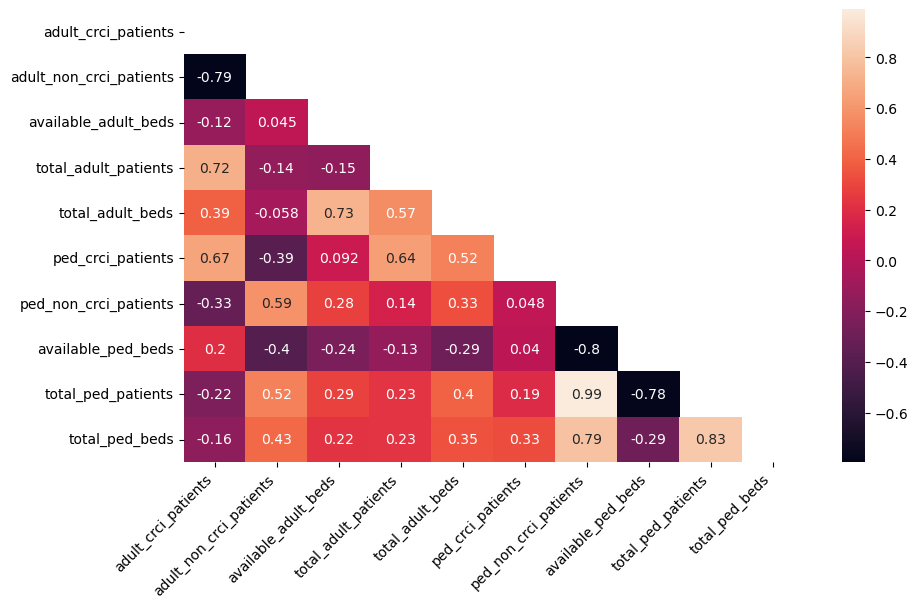

In [13]:
# Quick heat map check

corr_matrix = df_icu_beds.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_icu_beds.corr(), ax=ax, mask=mask, annot=True)
ax.set_xticklabels(labels=corr_matrix.columns, rotation=45, ha='right');

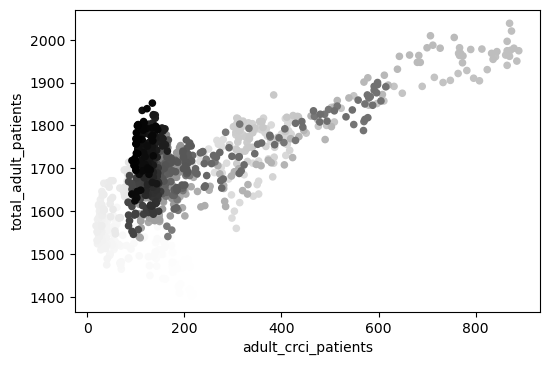

In [67]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# ax[0].plot(df_icu_beds['adult_crci_patients'])
# ax[0].fill_between(df_icu_beds.index, 
#                    df_icu_beds['total_adult_patients'], alpha=0.3)
# ax[0].set_xlim(df_icu_beds.index[0], df_icu_beds.index[-1])
# ax[0].set_ylim(0,2000)
# ax[0].set_xticks(df_icu_beds[~df_icu_beds.index.year.duplicated()].index)
# set_timeline(ax[0])
# df_icu_beds.plot(kind='scatter', x='adult_crci_patients', y='total_adult_patients',
#                  ax=ax[1], c=df_icu_beds.index)
# fig.tight_layout()

df_icu_beds.plot(kind='scatter', x='adult_crci_patients', y='total_adult_patients', c=df_icu_beds.index);

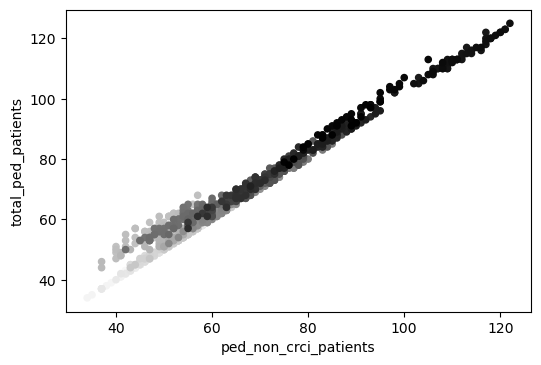

In [68]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# ax[0].plot(df_icu_beds['ped_non_crci_patients'], color='C1', alpha=0.5)
# ax[0].fill_between(df_icu_beds.index, 
#                    df_icu_beds['total_ped_patients'], color='C1', alpha=0.5)
# ax[0].set_xlim(df_icu_beds.index[0], df_icu_beds.index[-1])
# ax[0].set_ylim(0,130)
# ax[0].set_xticks(df_icu_beds[~df_icu_beds.index.year.duplicated()].index)
# set_timeline(ax[0])
# df_icu_beds.plot(kind='scatter', x='ped_non_crci_patients', y='total_ped_patients',
#                  ax=ax[1], c=df_icu_beds.index)
# fig.tight_layout()

df_icu_beds.plot(kind='scatter', x='ped_non_crci_patients', y='total_ped_patients', c=df_icu_beds.index)

In [16]:
# df_icu_beds.Multi_index
# df_adult_beds.index = pd.MultiIndex.from_arrays([df_adult_beds.index.year, df_adult_beds.index.month], names)

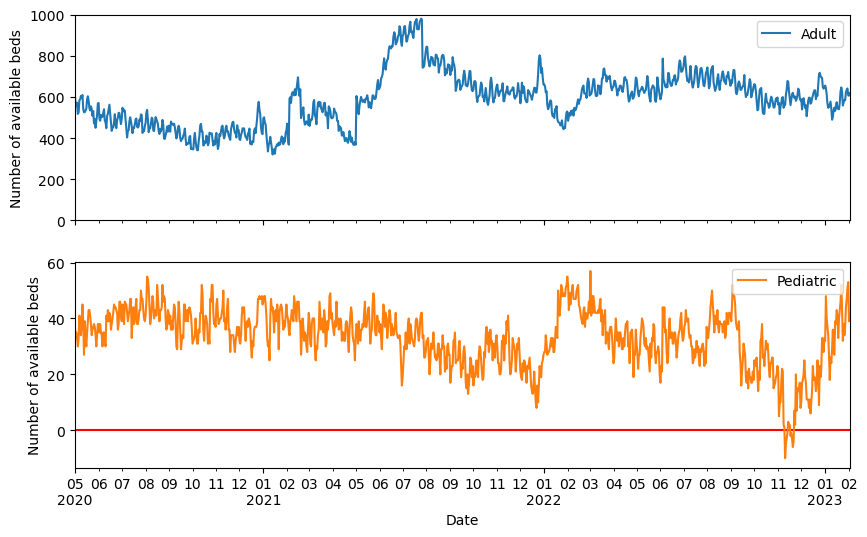

In [57]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
# ax[0].fill_between(df_icu_beds.index, 
#                    df_icu_beds['available_adult_beds'], alpha=0.5, where=df_icu_beds['available_adult_beds']>0)

ax[0].plot(df_icu_beds['available_adult_beds'])
ax[0].set_ylim(0, 1000)
ax[0].set_ylabel('Number of available beds')
ax[0].legend(['Adult'], loc='upper right')

# ax[1].fill_between(df_icu_beds.index, 
#                    df_icu_beds['available_ped_beds'], alpha=0.5, where=df_icu_beds['available_ped_beds']>0)
# ax[1].fill_between(df_icu_beds.index, 
#                    df_icu_beds['available_ped_beds'], alpha=0.5, where=df_icu_beds['available_ped_beds']<0, fc='red')
ax[1].plot(df_icu_beds['available_ped_beds'], color='C1')
ax[1].hlines(y=0, xmin=df_icu_beds.index[0], xmax=df_icu_beds.index[-1], color='red')
ax[1].set_ylabel('Number of available beds')
ax[1].legend(['Pediatric'], loc='upper right')
ax[1].set_xlim(df_icu_beds.index[0], df_icu_beds.index[-1])
ax[1].set_xticks(df_icu_beds[~df_icu_beds.index.year.duplicated()].index)
set_timeline(ax[1])

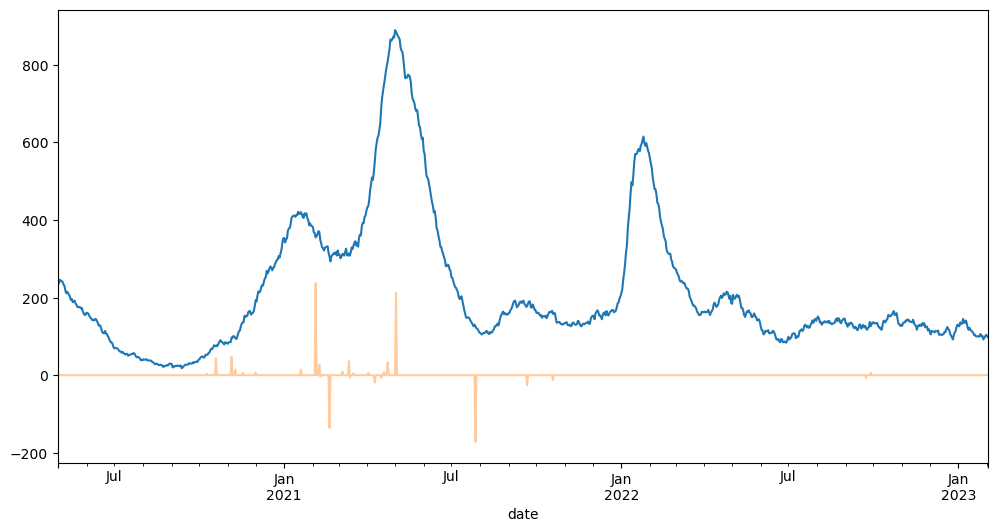

In [18]:
df_adults = df_icu_beds[['adult_crci_patients','total_adult_beds']].copy()
diff = df_adults.iloc[1:] - df_adults.shift().iloc[1:]
fig, ax = plt.subplots(figsize=(12, 6))
(df_icu_beds['adult_crci_patients']).plot(ax=ax)
(diff['total_adult_beds']).plot(ax=ax, alpha=0.4)

In [72]:
diff['adult_crci_patients']

date
2020-05-02    -8.0
2020-05-03    10.0
2020-05-04    -3.0
2020-05-05     0.0
2020-05-06    -3.0
              ... 
2023-01-29     4.0
2023-01-30     4.0
2023-01-31     4.0
2023-02-01    -3.0
2023-02-02    -3.0
Name: adult_crci_patients, Length: 1007, dtype: float64

In [ ]:
# from pandas.plotting import autocorrelation_plot
# autocorrelation_plot(df_icu_beds['adult_crci_patients'])

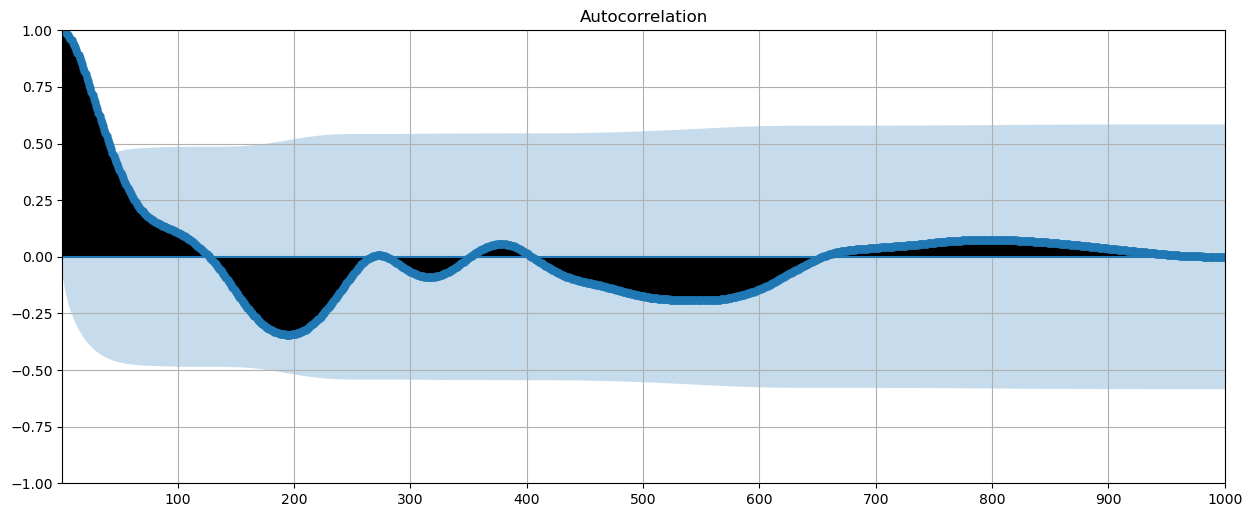

In [81]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df_icu_beds.adult_crci_patients, zero=False, lags=1007, ax=ax)
ax.set(xticks=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
       xlim=[1, 1000]);
# ax1[row, col].set_title(company, x=0.5, y=0.9)
# ax1[row, col].set(xticks=[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60],
#                   xlim=[1, 59],
#                   xlabel='Lag (month)',
#                   ylabel='ACF')
# ax1[row, col].tick_params(direction='in')
ax.grid()